In [1]:
import torch
from torch import nn, optim
from torch.utils.data import DataLoader
from statistics import mean

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
import seaborn as sns

from himodule.custom_classes import NasaDataset, SimpleAE, split_dataset, seed_everything, split_anomaly_normal, AnomalyLoader, LossAndMetric
from himodule.ae_metrics import MAPE
from himodule.normalisation import StandardScaler, MinMaxScaler
from himodule.secondary_funcs import save_object, load_object, check_path

from collections import defaultdict

import os
import pickle
from typing import Tuple

sns.set_theme(style='whitegrid', font_scale=1.2)

In [2]:
# Check for GPU availability

device = "cuda" if torch.cuda.is_available() else "cpu"
print(f'{device=}')

device='cuda'


### Training

In [4]:
seed = 37

# Whole dataset loading
train_dataset = NasaDataset('../datasets/clean_train_data.csv')
# Separate normal and anomaly data
train_dataset, anomaly_dataset = split_anomaly_normal(train_dataset)
seed_everything(seed)
# Get datasets for training and validation
train_dataset, val_dataset = split_dataset(train_dataset, test_size=0.3)

# Test dataset loading
test_dataset = NasaDataset('../datasets/clean_test_data.csv')

scaler = MinMaxScaler()
try:
    norm_name = repr(scaler).split(' ', maxsplit=2)[0].split('.')[-1]
except IndexError:
    norm_name = 'no_scaling'
for idx, dtset in enumerate((train_dataset, val_dataset, test_dataset, anomaly_dataset)):
    dtset.to(device)
    if scaler:
        if idx == 0:
            scaler.fit(dtset.dataset)
        dtset.dataset = scaler.transform(dtset.dataset)

# Save trained scaler to use it in another files
scaler_path = os.path.join('../scalers/', f'{norm_name}.pkl')
if scaler and not os.path.exists(scaler_path):
    save_object(scaler, scaler_path)

seed_everything(seed)
g = torch.Generator()
g.manual_seed(seed)
train_loader = DataLoader(train_dataset, batch_size=20, shuffle=True, worker_init_fn=seed, generator=g)
seed_everything(seed)
val_loader = DataLoader(train_dataset, batch_size=20, shuffle=True, worker_init_fn=seed, generator=g)

seed_everything(seed)
test_loader = DataLoader(val_dataset, batch_size=20, shuffle=True, worker_init_fn=seed, generator=g)

seed_everything(seed)
anomaly_loader = AnomalyLoader(anomaly_dataset, batch_size=20)

print(f'Train: {len(train_dataset)}\nValidation: {len(val_dataset)}\nTest: {len(test_dataset)}')
print(f'Anomaly: {len(anomaly_dataset)}')

input_shape = train_dataset.get_input_shape()
layers_sizes = (8, 4, 2)

# Model creating
seed_everything(seed)
model_ae = SimpleAE(input_shape, layers_sizes).to(device)
loss_func = nn.MSELoss()
metric_func = MAPE()
get_loss_and_metric = LossAndMetric(loss_func, metric_func, scaler)
get_loss_and_metric_anomaly = LossAndMetric(nn.MSELoss(reduction='none'), metric_func, scaler)
optimiser = optim.AdamW(model_ae.parameters(),
                       lr=1e-3)
optimiser_name = repr(optimiser).split(' ', maxsplit=1)[0]

Train: 5960
Validation: 2171
Test: 13096
Anomaly: 12500


In [16]:
def evaluate_model(model: nn.Module, loader: DataLoader) -> Tuple[list, list]:

    '''Returns losses and metrics of trained model.'''

    with torch.no_grad():
        losses = list()
        metrics = list()
        for dta in loader:
            sample = dta['sensors']
            sample = sample.to(device)
            _, reconstruction = model(sample)

            loss, metric = get_loss_and_metric(reconstruction, sample)

            losses.append(loss.item())
            metrics.append(metric.item())
    return losses, metrics

In [ ]:
models_path = '../Models/norm-anom/'

epochs = 100
history = list()

# Model training on normal data only

for epoch in range(epochs):
    train_losses = list()
    train_metrics = list()
    for dta in train_loader:
        sample = dta['sensors']
        sample = sample.to(device)
        _, reconstruction = model_ae(sample)

        loss, metric = get_loss_and_metric(reconstruction, sample)

        optimiser.zero_grad()
        loss.backward()
        optimiser.step()

        train_losses.append(loss.item())
        train_metrics.append(metric.item())
    
    val_losses, val_metrics = evaluate_model(model_ae, val_loader)
    
    train_loss, val_loss = mean(train_losses), mean(val_losses)
    train_metrics, val_metrics = mean(train_metrics), mean(val_metrics)
    history.append((epoch, train_loss, val_loss, train_metrics, val_metrics))
    if (epoch + 1) % 10 == 0 or epoch == epochs - 1:
        print(f'{epoch+1:>3}/{epochs:>3}: {train_loss=:.4f}, {val_loss=:.4f}, {train_metrics=:.4f}%, {val_metrics=:.4f}%')

test_losses, test_metrics = evaluate_model(model_ae, test_loader)
test_loss = mean(test_losses)
test_metric = mean(test_metrics)
print(f'\n{test_loss=:.4f}, {test_metric=:.4f}%')


with torch.no_grad():
    anomaly_losses = defaultdict(list)
    anomaly_metrics = list()
    for dta in anomaly_loader:
        sample = dta['sensors']
        machine_id = dta['machine_id'][0].item()
        sample = sample.to(device)
        _, reconstruction = model_ae(sample)
        
        loss, metric = get_loss_and_metric_anomaly(reconstruction, sample)
        anomaly_losses[int(machine_id)].append(loss.mean(dim=1))
        anomaly_metrics.append(metric)
    
    for key, values in anomaly_losses.items():
        anomaly_losses[key] = torch.hstack(values)


#-----------------------------------------------------------#
# Model saving
check_path(models_path)
torch.save(model_ae.state_dict(), os.path.join(models_path, f'{layers_sizes}.pth'))

## Plots

In [18]:
def transform_train_history(history: list) -> pd.DataFrame:

    '''Transfrorms training history to format for plot.'''

    columns = ('epoch', 'train_loss', 'val_loss', 'train_metric', 'val_metric')
    total_history_df = pd.DataFrame(history, columns=columns).set_index('epoch')

    history_df = total_history_df.loc[:,('train_loss', 'val_loss')].iloc[2:].melt(ignore_index=False)
    return history_df


def transform_anomaly_history(history: dict):

    '''Transfrorms history of anomalies reconstructions to format for plot.'''

    counter = 0
    dfs = list()
    for machine_id, losses in history.items():
        if counter == 3:
            yield pd.concat(dfs, axis=1, ignore_index=False).melt(ignore_index=False)
            counter = 0
            dfs = list()
        
        dfs.append(pd.Series(losses.cpu(), name=machine_id))
        counter += 1


def plot_lines(ax: plt.Axes, history_df: pd.DataFrame, anomaly_df: dict, title: str = None):
    sns.lineplot(data=history_df,
                x=history_df.index,
                y='value',
                hue='variable',
                ax=ax)

    sns.lineplot(data=anomaly_df,
                x=anomaly_df.index,
                y='value',
                hue='variable',
                ax=ax)
    
    ax.legend()
    ax.set_title(title)

    ax.set_ylabel('MSE')

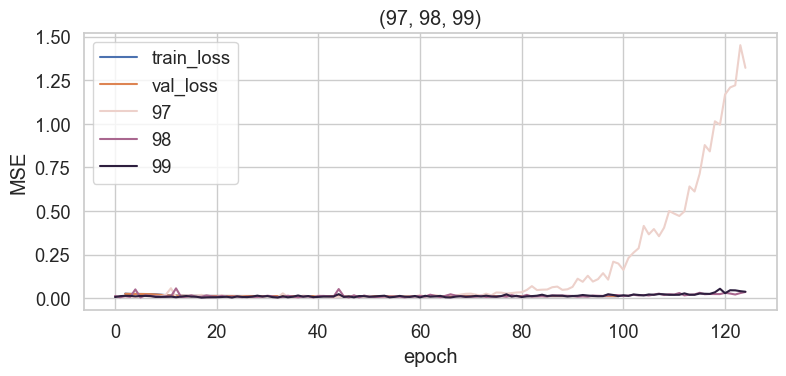

In [17]:
# Plot lines of anomaly reconstruction MSE (for each machine individual line) and training history lines

history_df = transform_train_history(history)

for anomaly_df in transform_anomaly_history(anomaly_losses):
    plt.close()
    fig, ax = plt.subplots()
    fig.set_size_inches(8, 4)
    title = tuple(anomaly_df['variable'].unique())
    plot_lines(ax, history_df, anomaly_df, title=title)

    plt.tight_layout()
    plt.savefig(f'../Plots/history/norm-anom/{title}.png')

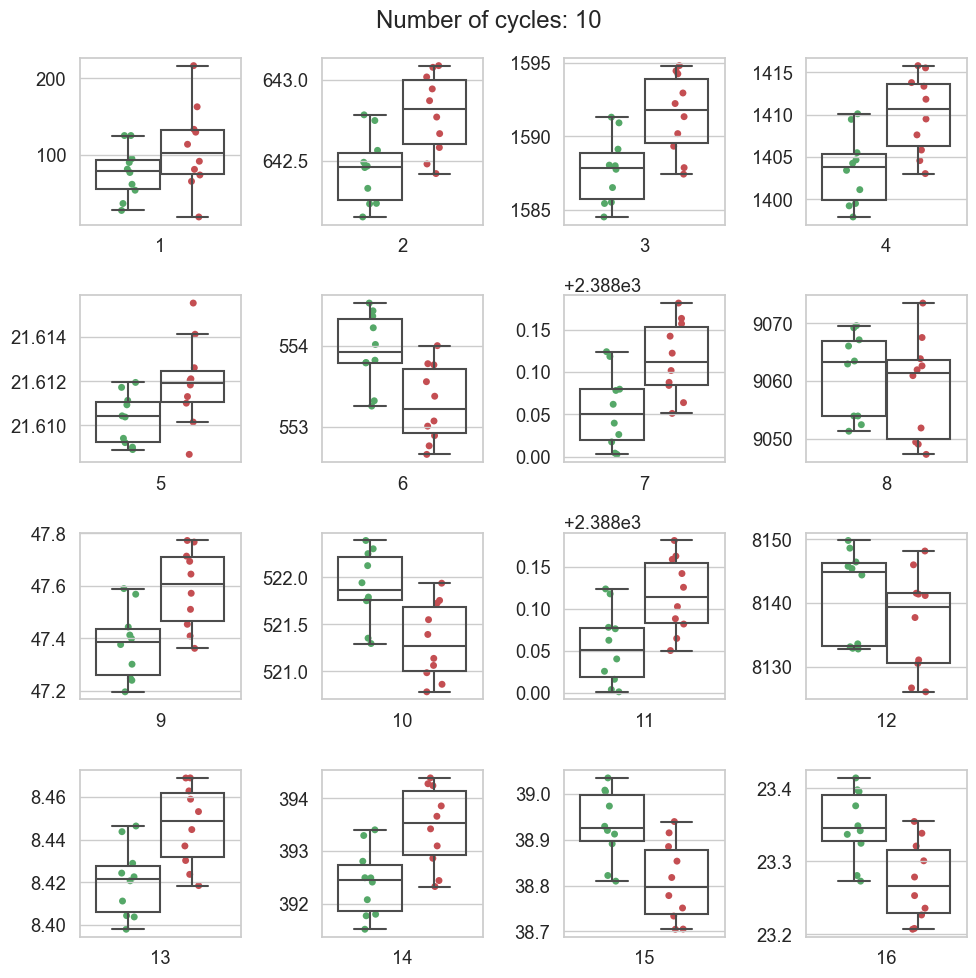

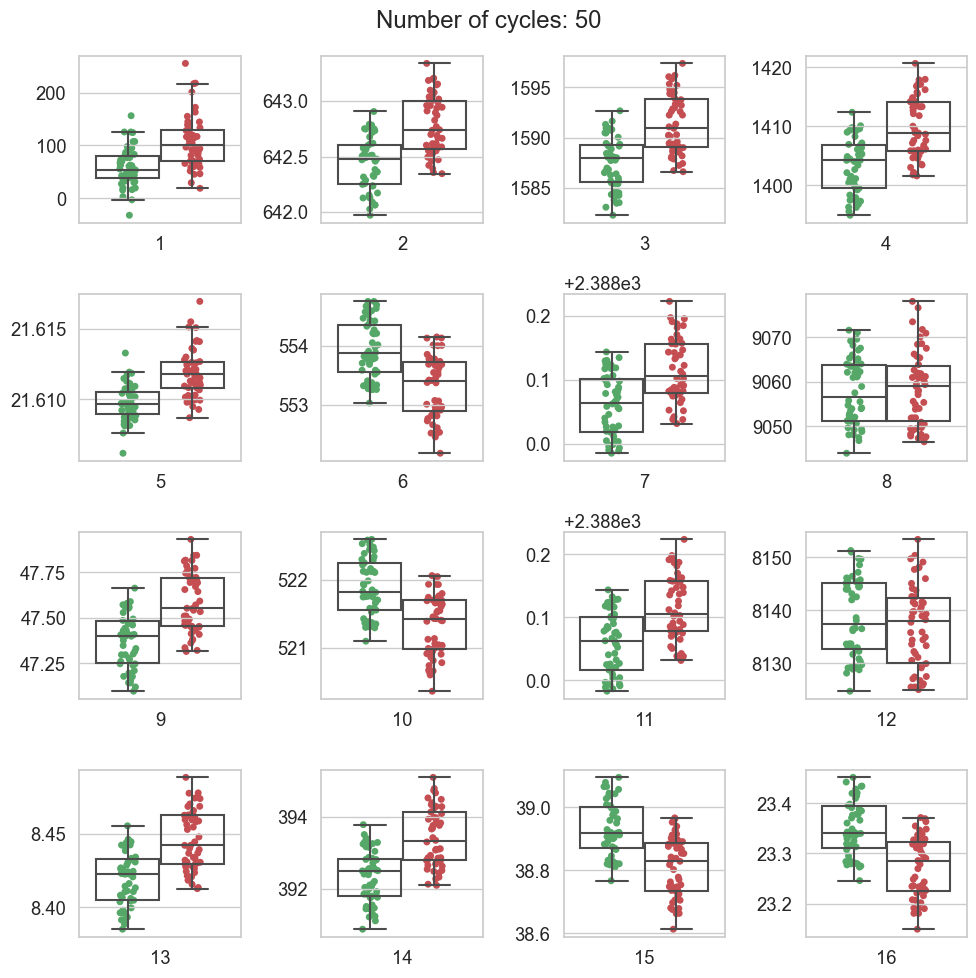

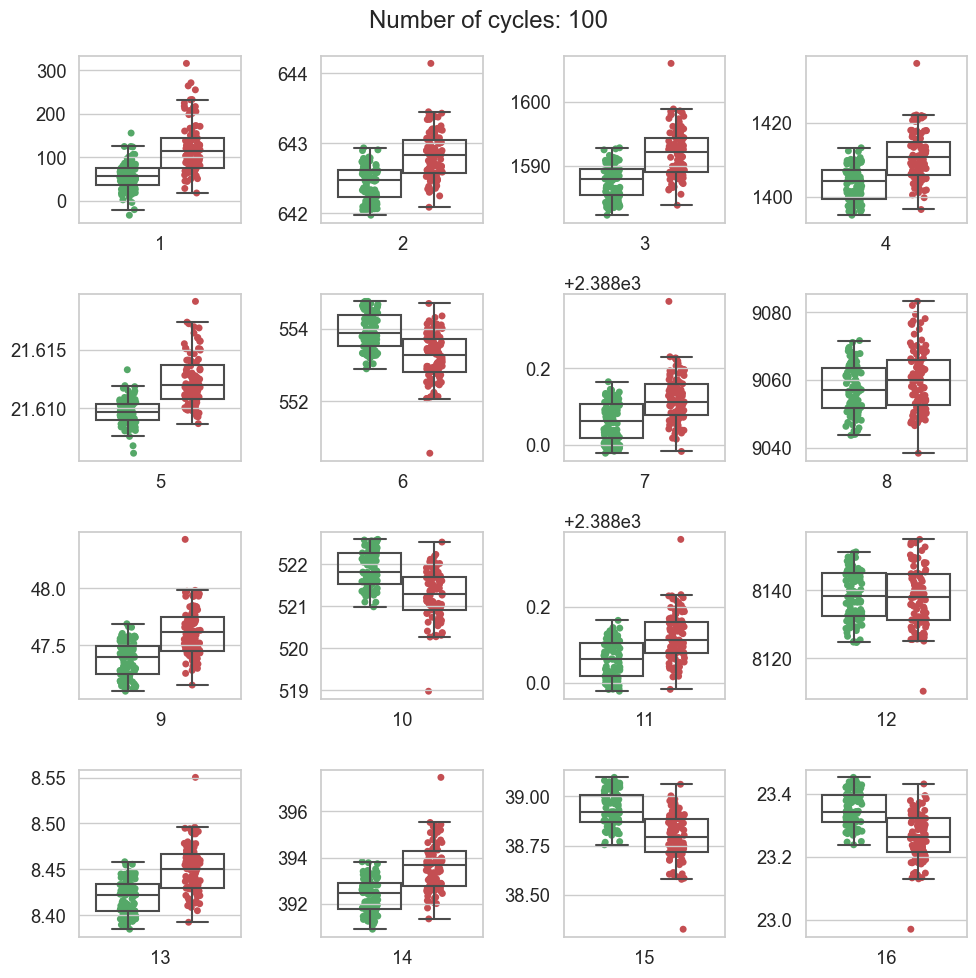

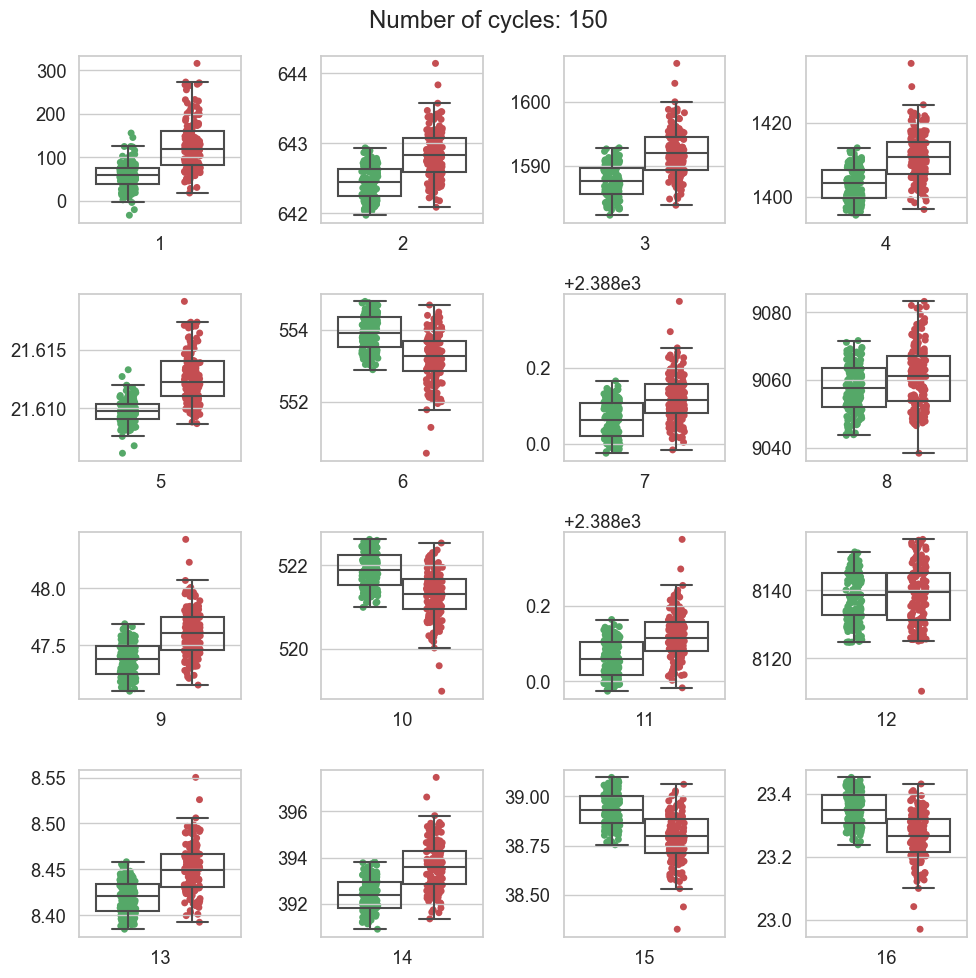

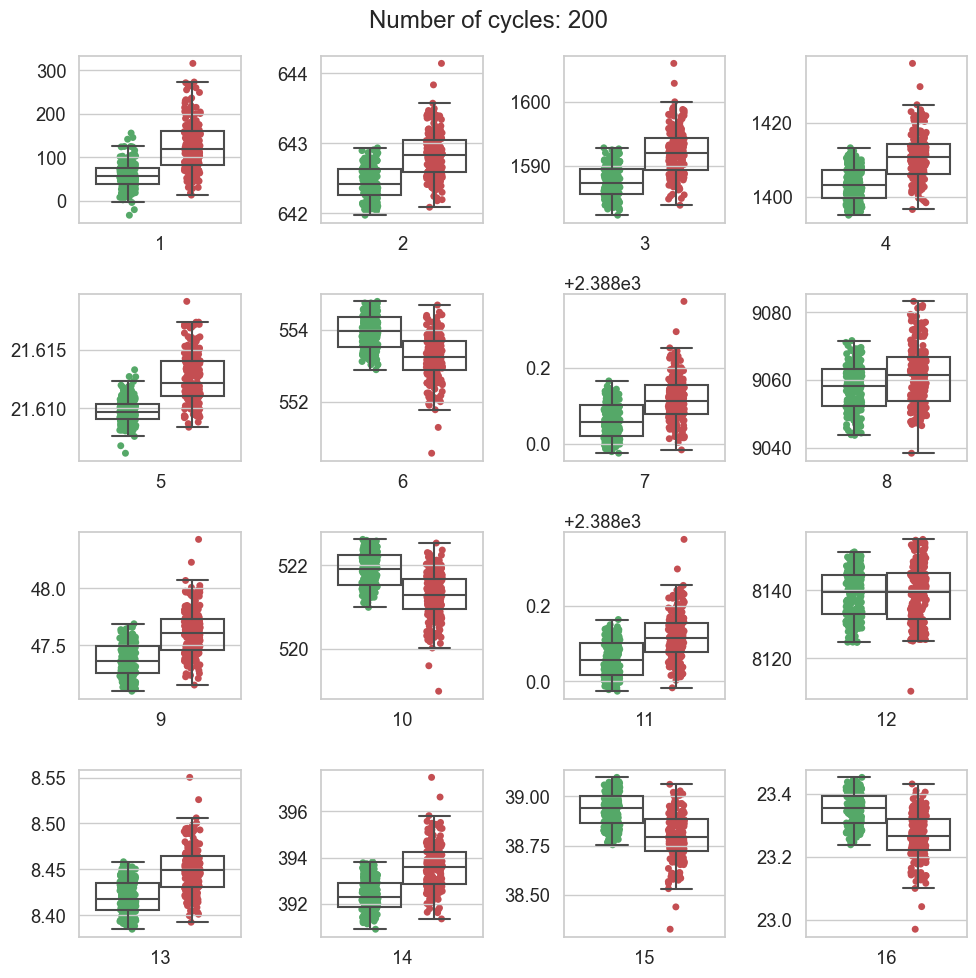

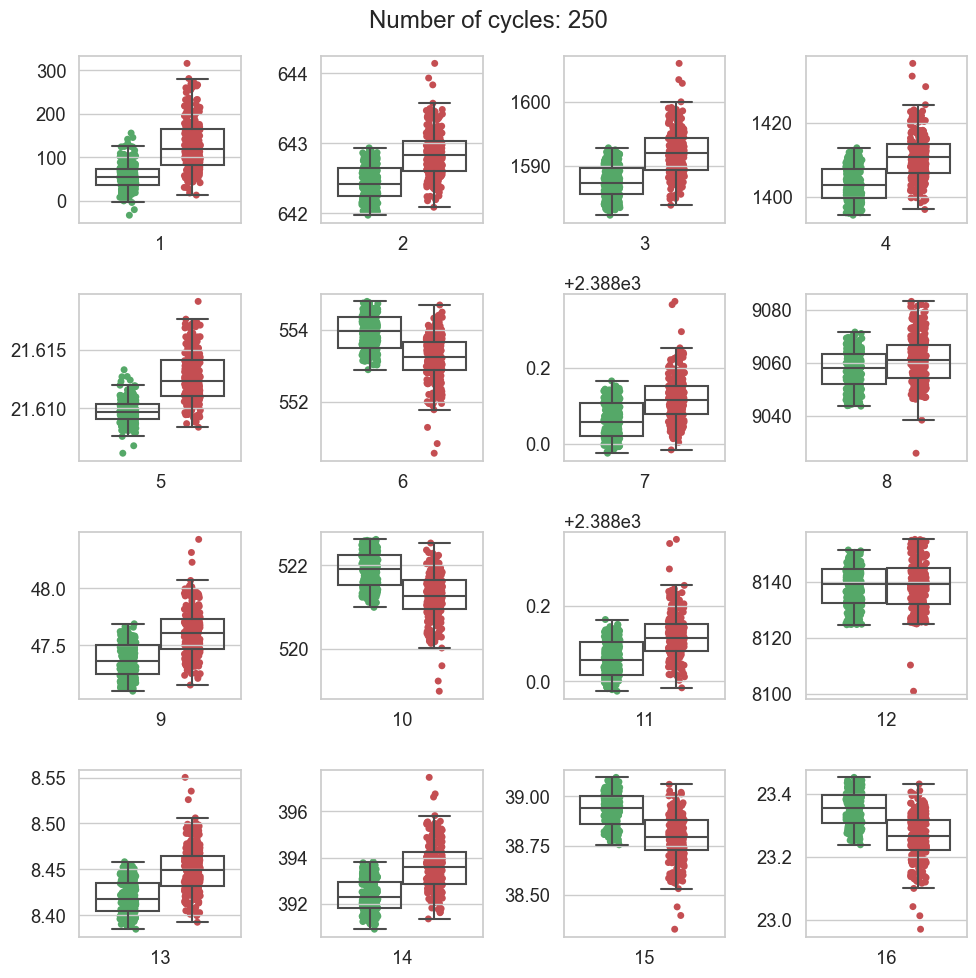

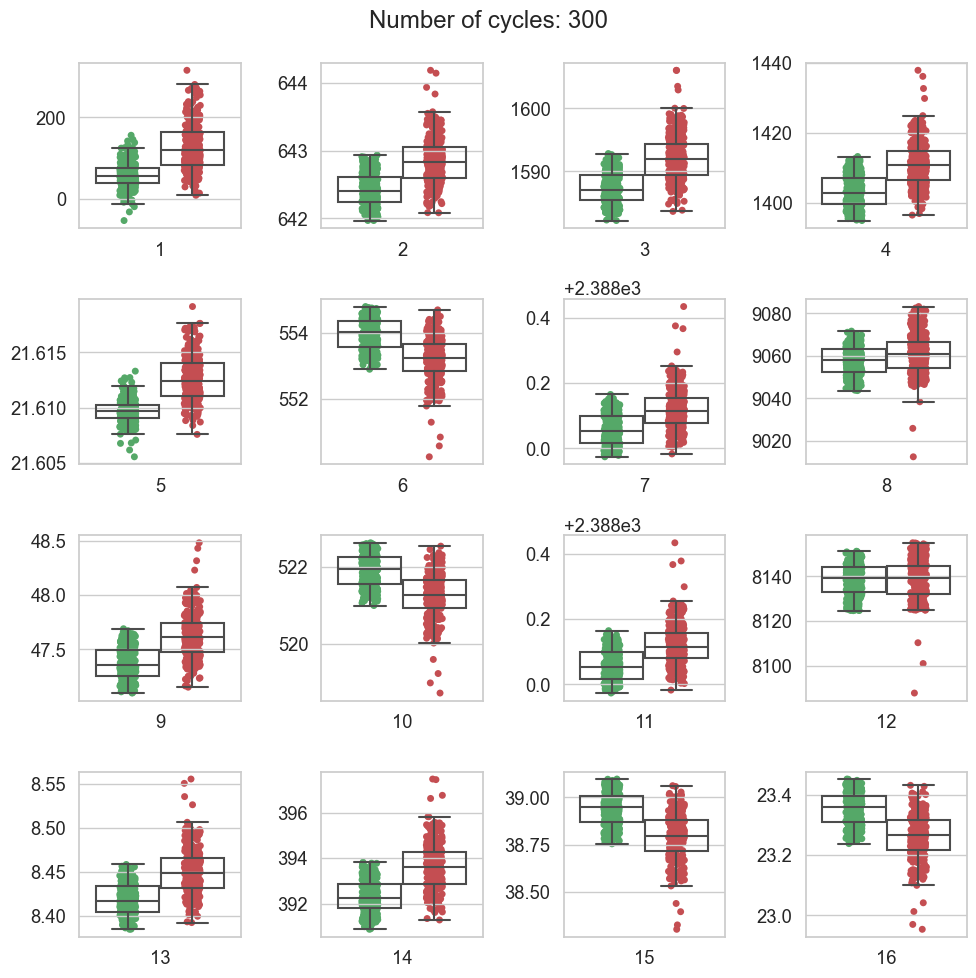

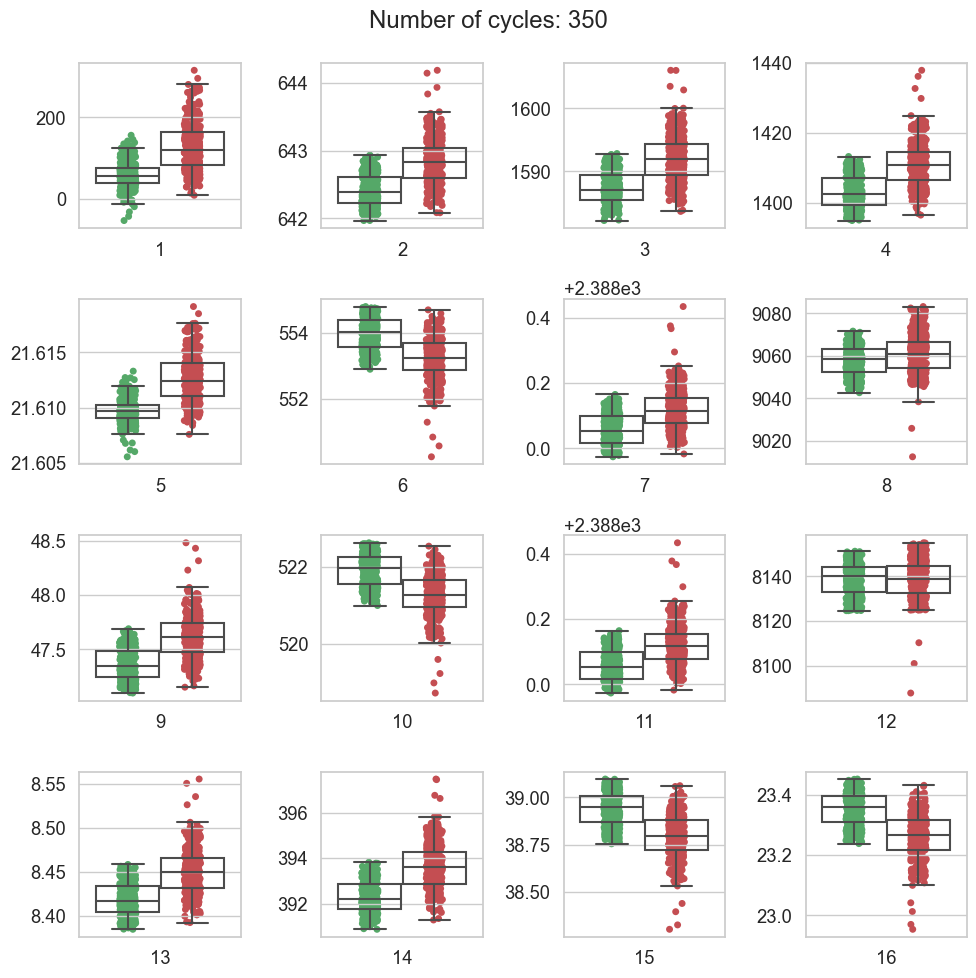

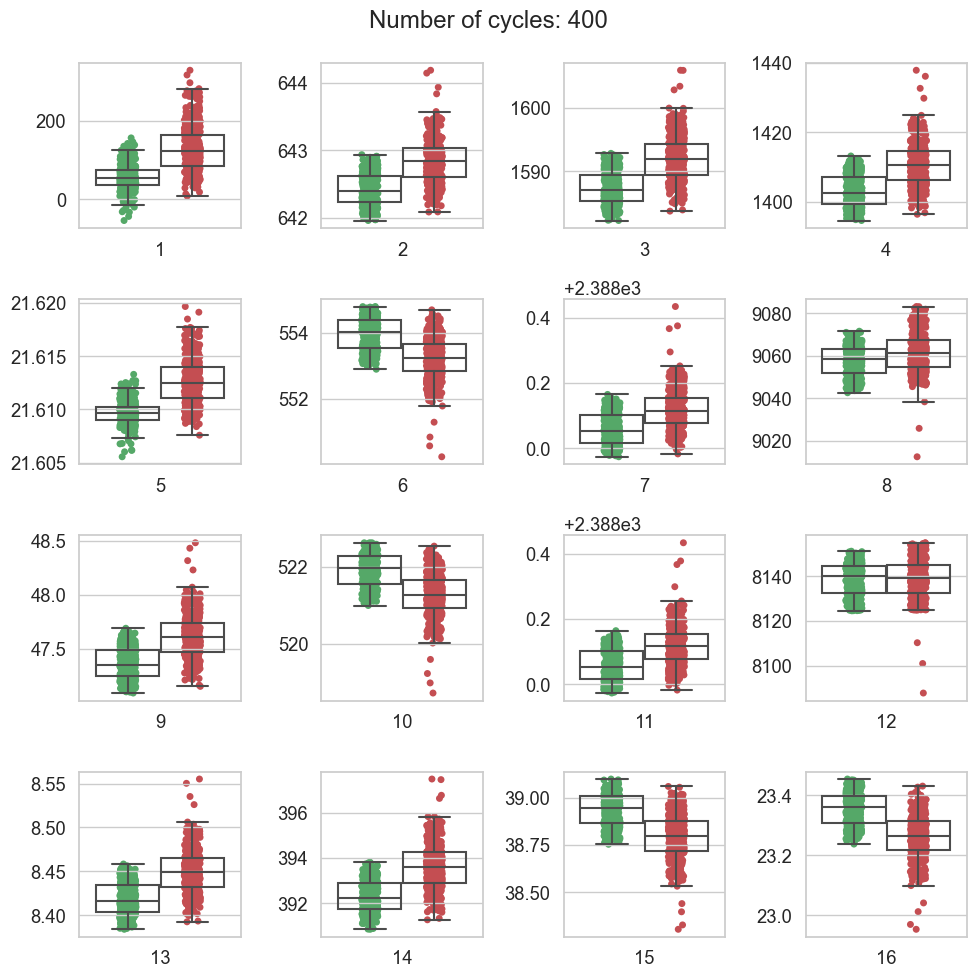

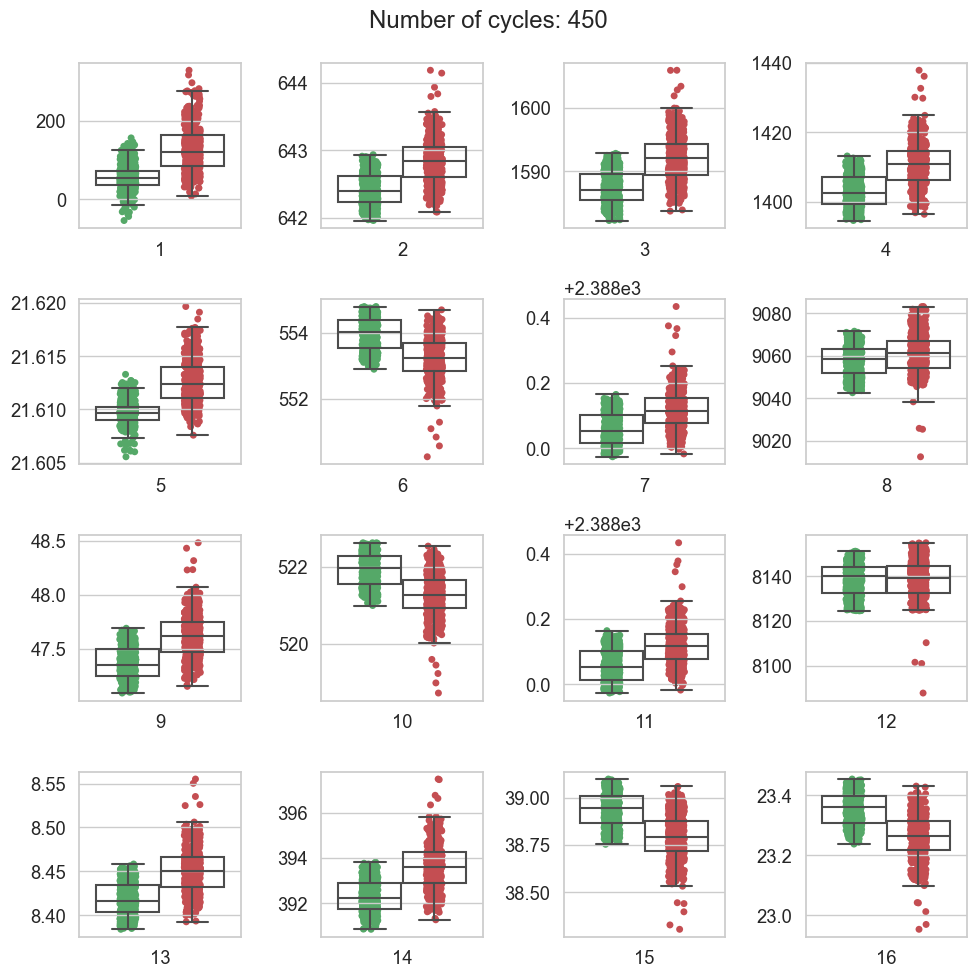

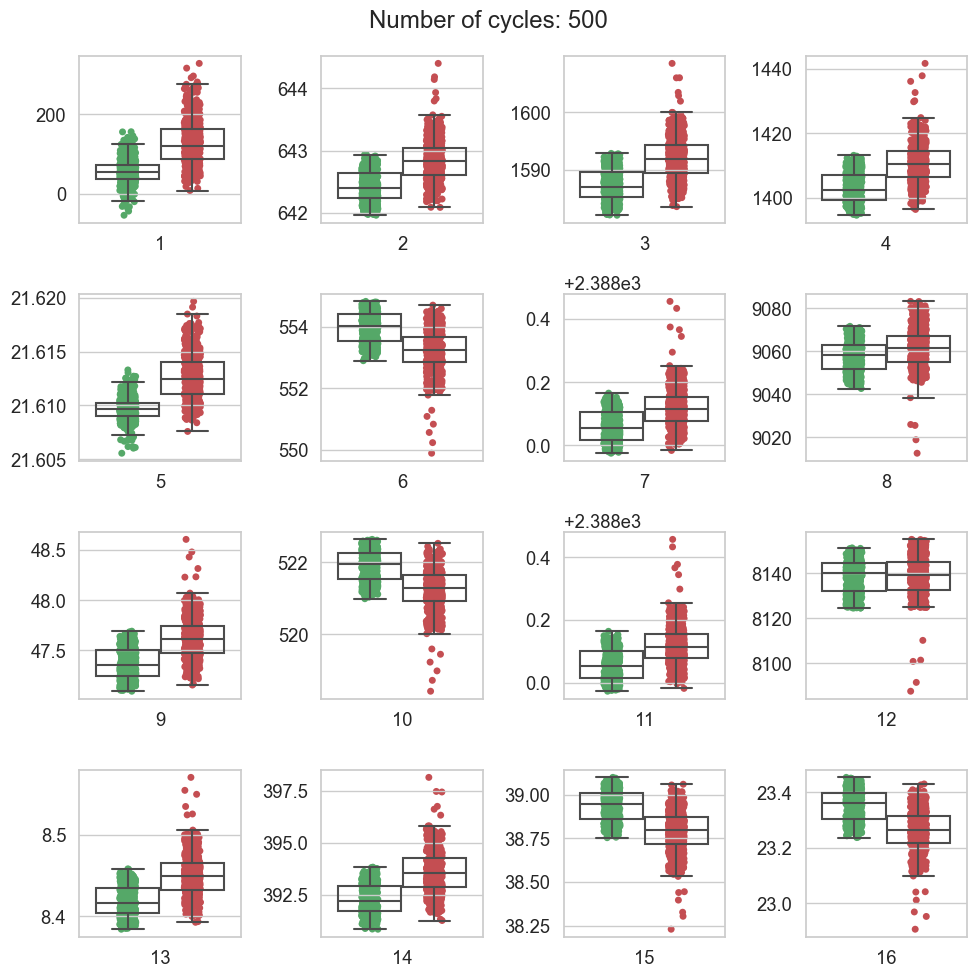

In [31]:
seed = 37

plot_path = '../Plots/reconstruction_visualisation/'
check_path(plot_path)

for n_cycles in (10, 50, 100, 150, 200, 250, 300, 350, 400, 450, 500):
    g = torch.Generator()
    g.manual_seed(seed)
    seed_everything(seed)
    normal_data = train_dataset[torch.randperm(len(train_dataset), generator=g)[:n_cycles]]['sensors']
    seed_everything(seed)
    anomaly_data = anomaly_dataset[torch.randperm(len(anomaly_dataset), generator=g)[:n_cycles]]['sensors']

    with torch.no_grad():
        _, normal_reconstruction = model_ae(normal_data)
        _, anomaly_reconstruction = model_ae(anomaly_data)
        normal_reconstruction = scaler.inverse_transform(normal_reconstruction)
        anomaly_reconstruction = scaler.inverse_transform(anomaly_reconstruction)

    columns = [i+1 for i in range(normal_reconstruction.shape[1])]
    normal_df = pd.DataFrame(normal_reconstruction.cpu(), columns=columns).melt()
    normal_df['type'] = 'normal'
    anomaly_df = pd.DataFrame(anomaly_reconstruction.cpu(), columns=columns).melt()
    anomaly_df['type'] = 'anomaly'
    df = pd.concat((normal_df, anomaly_df), axis=0)

    plt.close()
    fig, axes = plt.subplots(4, 4)
    fig.set_size_inches(10, 10)

    for ax, sensor_id in zip(axes.flatten(), df['variable'].unique()):
        
        sns.stripplot(data=df[df['variable'] == sensor_id],
                    x='variable',
                    y='value',
                    hue='type',
                    palette=['g', 'r'],
                    dodge=True,
                    ax=ax,
                    zorder=0)
        
        sns.boxplot(data=df[df['variable'] == sensor_id],
                    x='variable',
                    y='value',
                    hue='type',
                    boxprops={"facecolor": (0, 0, 0, 0)},
                    showfliers=False,
                    ax=ax,
                    zorder=1)

        ax.set_ylabel(None)
        ax.set_xlabel(None)
        ax.get_legend().remove()

    fig.suptitle(f'Number of cycles: {n_cycles}')

    plt.tight_layout()
    plt.savefig(os.path.join(plot_path, f'{n_cycles}.png'))